# Library documentation

The `beet` library is the foundation that supports the entire project. It provides the necessary abstractions for working with Minecraft data packs and resource packs at a higher level than through filesystem operations. This enables code that uses the `beet` library to easily introspect and make modifications to data packs and resource packs.

This page is still a work-in-progress so for the time being we've tried to compile a bunch of useful code snippets. You can read everything from top to bottom but it's primarily supposed to serve as a quick reference that you can easily search through.

---

## Data packs and resource packs

TODO

## Creating files

Manipulating individual files should be pretty uncommon since `beet` makes it easy to perform operations at the pack level, but it's still probably a good idea to be at least a little bit familiar with the primitives that the rest of the library builds upon.

You can create a new file by providing the file content to the constructor or by specifying a source path from which the file should be loaded.

In [1]:
from beet import TextFile

text_file = TextFile("Hello, world!")
text_file

TextFile(content='Hello, world!', source_path=None)

In [2]:
text_file.text

'Hello, world!'

The dump method lets you write the file to the filesystem. You can then load the file back by using the load classmethod.

In [3]:
from pathlib import Path

files = Path("library_files")
files.mkdir(exist_ok=True)

text_file.dump(files, "hello.txt")

TextFile.load(files, "hello.txt")

TextFile(content=None, source_path=PosixPath('library_files/hello.txt'))

Here you'll notice the first notable difference with the built-in file handles. The file instance doesn't load the file unless it has to. You can see that the content is set to None and that instead of loading the file, `beet` simply stored a reference to the original source path.

The file will only be loaded when trying to access the content of the file. This allows `beet` to let you access all the resources in data packs and resource packs without ever loading everything at once.

In [4]:
text_file = TextFile.load(files, "hello.txt")
print(text_file.text)  # This is where beet actually loads the file
text_file

Hello, world!


TextFile(content='Hello, world!', source_path=None)

Notice that after accessing the text property, the representation of the file changes and shows that the content of the file is loaded and that the reference to the original file was discarded.

## Storing files in zipfiles

The dump and load methods can be used with zipfiles. Zipfiles should be in write mode when writing and in read mode (the default mode) when reading.

In [5]:
from zipfile import ZipFile

with ZipFile(files / "test1.zip", mode="w") as zipfile:
    text_file.dump(zipfile, "hello.txt")

TextFile.load(ZipFile(files / "test1.zip"), "hello.txt")

TextFile(content='Hello, world!', source_path=None)

Notice that the content of the file is loaded up-front. There's no reliable way to keep a valid reference to a zipfile entry, so `beet` doesn't implement lazy-loading for zipfiles. The good news is that with zipfiles, the entire content of the zipfile is very likely already in memory, so the performance impact should be negligible.

## Json files

The library provides rich content files that are automatically deserialized as python objects.

In [6]:
from beet import JsonFile

json_file = JsonFile({"hello": "world"})
json_file

JsonFile(content={'hello': 'world'}, source_path=None)

In [7]:
json_file.data

{'hello': 'world'}

You can also access and make modifications to the serialized version of the file at any time.

In [8]:
json_file.text

'{\n  "hello": "world"\n}\n'

In [9]:
json_file

JsonFile(content='{\n  "hello": "world"\n}\n', source_path=None)

## Lazy deserialization

You've probably noticed that the content is stored depending on how you're using the file. The content will be stored as text if you're accessing the text property. If you're accessing the data property `beet` will deserialize the content on-the-fly and update the file's internal state.

In [10]:
json_file.data["number"] = 42
print(json_file.text)
json_file

{
  "hello": "world",
  "number": 42
}



JsonFile(content='{\n  "hello": "world",\n  "number": 42\n}\n', source_path=None)

In [11]:
json_file.dump(files, "hello.json")

JsonFile.load(files, "hello.json")

JsonFile(content=None, source_path=PosixPath('library_files/hello.json'))

In [12]:
JsonFile.load(files, "hello.json").data["number"]

42

## Binary files

Each file belongs to one of two distinct hierarchies: text files and binary files. The difference is that text files store their serialized content as strings while binary files store their serialized content as bytes. On binary files, you can use the blob property to access the seriliazed content of the file.

In [13]:
from beet import BinaryFile

binary_file = BinaryFile(b"\x01\x02\x03")
binary_file.blob

b'\x01\x02\x03'

In [14]:
binary_file.dump(files, "hello.bin")

BinaryFile.load(files, "hello.bin")

BinaryFile(content=None, source_path=PosixPath('library_files/hello.bin'))

In [15]:
BinaryFile.load(files, "hello.bin").blob

b'\x01\x02\x03'

## Image files

Png files are binary files that get deserialized to PIL images.

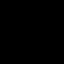

In [16]:
from beet import PngFile
from PIL import Image

png_file = PngFile(Image.new("RGB", (64, 64), color="black"))
png_file.image

In [17]:
png_file.dump(files, "black.png")

PngFile.load(files, "black.png")

PngFile(content=None, source_path=PosixPath('library_files/black.png'))

In [18]:
PngFile.load(files, "black.png").blob

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x02\x00\x00\x00%\x0b\xe6\x89\x00\x00\x00"IDATx\x9c\xed\xc1\x01\r\x00\x00\x00\xc2\xa0\xf7Om\x0f\x07\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0n0@\x00\x01\x8b\x00\xa8\xf7\x00\x00\x00\x00IEND\xaeB`\x82'

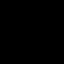

In [19]:
PngFile.load(files, "black.png").image

You can use PIL utilities to resize images, make modifications, apply filters...

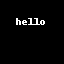

In [20]:
from PIL.ImageDraw import Draw

d = Draw(png_file.image)
d.text((16, 16), "hello", fill="white")

png_file.image

In [21]:
png_file.blob

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x02\x00\x00\x00%\x0b\xe6\x89\x00\x00\x00\x85IDATx\x9c\xed\xd2A\x0e\x83 \x10\x05P\xa6\xe9\xfd\xafL\x175\x84\x80\xd5\x804.|o\x89|\x19\x98I\t\x00\x00\x80{\xc4h \xe7\x9cR\x8a8\n~\xf7l\x07D\xec\xae\xac\xf2Z\xf8\xaf""\x9a*\xfb\x95U\xdes\xb1\xa6\x0f\xe5\x81\x87\xaa\x9cK5&;P\x0fF}\x99zT\x8e\xcd\xa5z\xcbF\xe8J\x11WL\x8eP\xefO#~~\xeeh\xa0\xb4\xfe\xd7\x0c\x94O\'\x07W\xdb\xee\xba<\x00\x00\x00\x00\x00\x00\xc0\x03}\x00\xfb\xc03\x17\xa6\xd1\x81q\x00\x00\x00\x00IEND\xaeB`\x82'